In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
from scipy.signal import savgol_filter

# Define utility functions

In [2]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

    
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


# Load Data

In [3]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


print("converting to dataframes of desired size")
x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

print("printing shapes of the dataframe")
x_train.shape, y_train.shape, x_test.shape

converting to dataframes of desired size
printing shapes of the dataframe


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

# Smooth output data 

We only smooth the open price (which is what we are tying to predict) 
We will not smooth other features (I don't know if this is the correct approach) 

In [6]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape 

(7661, 1500, 10)

In [7]:
price_data = full_df[:,:,[1,2,3,4]]  
volume_data = full_df[:,:,[5,6,7,8,9]] 

price_data.shape, volume_data.shape 

((7661, 1500, 4), (7661, 1500, 5))

In [10]:
open_price = price_data[:,:,0]
smoothed_open = np.zeros((7661,1500))
for i in tqdm(range(open_price.shape[0])): 
    smoothed = savgol_filter(open_price[i,:], 5, 3)
    smoothed_open[i,:] = smoothed
    
smoothed_open.shape

100%|██████████| 7661/7661 [00:04<00:00, 1813.31it/s]


(7661, 1500)

# Preprocess Data

In [13]:
K = 120 
N = 30 
seq_len = 1500 
price_features = 4 
volume_features = 5 
X_price = np.zeros(((seq_len-N-K)*price_data.shape[0], N, price_features)) 
X_volume = np.zeros(((seq_len-N-K)*volume_data.shape[0], N, volume_features)) 
Y_train = np.zeros(((seq_len-N-K)*price_data.shape[0])) 

cnt = 0 
for i in tqdm(range(price_data.shape[0]), position = 0, leave = True): 
    j = 0 
    while j+N+K < seq_len: 
        X_price[cnt, :, :] = price_data[i, j:j+N, :] 
        X_volume[cnt, :, :] = volume_data[i, j:j+N, :] 
        Y_train[cnt] = smoothed_open[i, j+N+K]  
        j += 1
        cnt += 1 
        
        
X_price.shape, X_volume.shape, Y_train.shape 

100%|██████████| 7661/7661 [00:44<00:00, 171.86it/s]


((10342350, 30, 4), (10342350, 30, 5), (10342350,))

# Define Model

In [14]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [27]:
def transformer_block(inputs, node, drop_rate, activation):
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs)
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon = 1e-6)(attn_output) 
    ffn_output = Dense(node, activation = activation)(out1)  
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)  
    out2 = LayerNormalization(epsilon = 1e-6)(out1 + ffn_output) 
    return out2 


def transformer_module(inputs, node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding = Time2Vector(N) 
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn,x]) 
    x = Conv1D(node*2, 5, activation = activation)(x)
    x = MaxPooling1D()(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D()(x) 
    x = Dropout(drop_rate)(x) 
    positions = tf.range(start = 0, limit = x.shape[1], delta = 1) 
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    for i in range(num_layers):
        x = transformer_block(x, node, drop_rate, activation) 
    x = GlobalAveragePooling1D()(x) 
    return x  

def build_model(): 
    price_inputs = Input((N, price_features)) 
    x_p = transformer_module(price_inputs) 
    
    volume_inputs = Input((N, volume_features)) 
    x_v = transformer_module(volume_inputs) 
    
    x = Concatenate()([x_p, x_v]) 
    x = Dense(x.shape[1]/2, activation = 'relu')(x) 
    x = BatchNormalization()(x) 
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=[price_inputs, volume_inputs], outputs=x)
    model.compile(loss='mape', optimizer='adam', metrics=['mae','mse','mape'])
    return model

In [28]:
model = build_model() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 30, 4)        16          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 30, 5)        20          input_10[0][0]                   
______________________________________________________________________________________________

# Train Model

In [29]:
model_path = 'transformer_target_smoothed_epoch_{epoch:03d}_val_mape_{val_loss:.3f}_val_mse_{val_mse:.3f}.h5'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5) 

checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)

history = model.fit([X_price, X_volume], 
                    Y_train, 
                    batch_size = 512,
                    epochs = 50, 
                    callbacks = [learning_rate_reduction, checkpoint, early_stopping], 
                    validation_split = 0.1) 

Epoch 1/50
18180/18180 [==============================] - 482s 25ms/step - loss: 2.8027 - mae: 0.0280 - mse: 0.0079 - mape: 2.8027 - val_loss: 1.4207 - val_mae: 0.0142 - val_mse: 4.5854e-04 - val_mape: 1.4207

Epoch 00001: val_loss improved from inf to 1.42073, saving model to transformer_target_smoothed_epoch_001_val_mape_1.421_val_mse_0.000.h5
Epoch 2/50
18180/18180 [==============================] - 435s 24ms/step - loss: 1.0568 - mae: 0.0106 - mse: 2.9281e-04 - mape: 1.0568 - val_loss: 1.6785 - val_mae: 0.0170 - val_mse: 6.1318e-04 - val_mape: 1.6785

Epoch 00002: val_loss did not improve from 1.42073
Epoch 3/50
18180/18180 [==============================] - 435s 24ms/step - loss: 1.0445 - mae: 0.0105 - mse: 2.8827e-04 - mape: 1.0445 - val_loss: 3.8341 - val_mae: 0.0382 - val_mse: 0.0017 - val_mape: 3.8341

Epoch 00003: val_loss did not improve from 1.42073
Epoch 4/50
18180/18180 [==============================] - 428s 24ms/step - loss: 1.0404 - mae: 0.0104 - mse: 2.8545e-04 - mape

KeyboardInterrupt: 

# Inference

In [30]:
best_model = load_model('transformer_target_smoothed_epoch_016_val_mape_0.977_val_mse_0.000.h5', custom_objects = {'Time2Vector': Time2Vector}) 

In [33]:
X_test_price = [] 
X_test_volume = [] 

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True):  
    for i in range(seq_len-K-N-120, seq_len-K-N): 
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]]) 
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]]) 
        
        
X_test_price = np.asarray(X_test_price).reshape((-1,N,price_features)) 
X_test_volume = np.asarray(X_test_volume).reshape((-1,N,volume_features))

X_test_price.shape, X_test_volume.shape 

100%|██████████| 535/535 [00:00<00:00, 1005.82it/s]


((64200, 30, 4), (64200, 30, 5))

In [34]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 

predicted.shape 

(535, 120)

In [35]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 119283.04it/s]


In [36]:
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_target_smoothed.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4052.57it/s]


In [37]:
submission 

,sample_id,buy_quantity,sell_time
0,7661,1.000000,110
1,7662,0.966667,42
2,7663,1.000000,95
3,7664,0.175000,23
4,7665,0.708333,114
...,...,...,...
530,8191,0.008333,0
531,8192,0.008333,0
532,8193,0.866667,82
533,8194,0.016667,1


# Visualize

In [41]:
pred_train = best_model.predict([X_price[:3600], X_volume[:3600]]) 
pred_train = pred_train.reshape((-1,120)) 

pred_train.shape 

(30, 120)

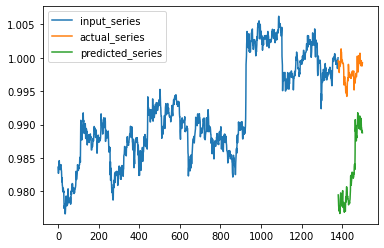

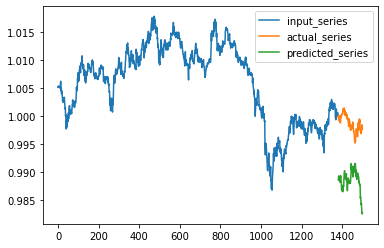

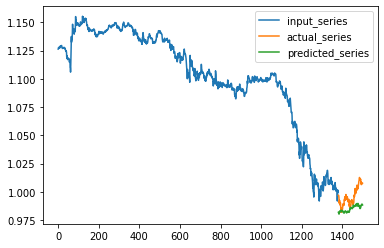

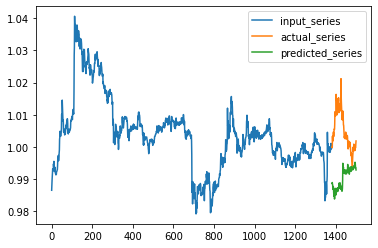

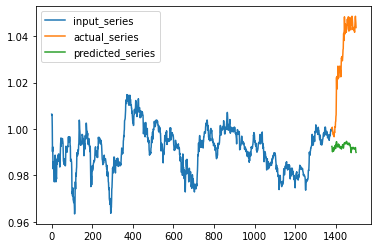

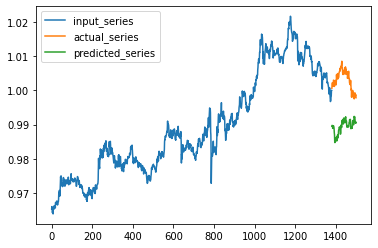

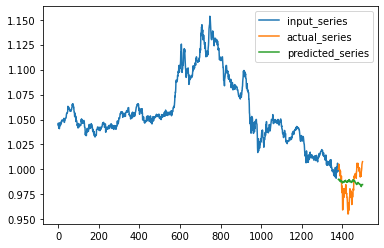

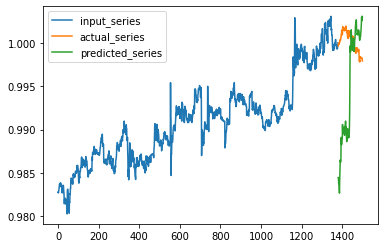

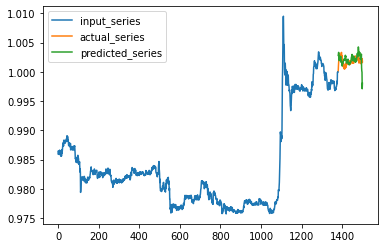

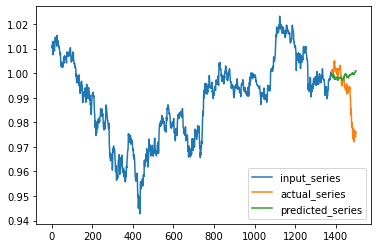

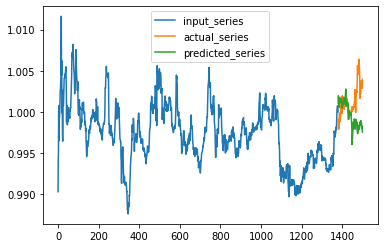

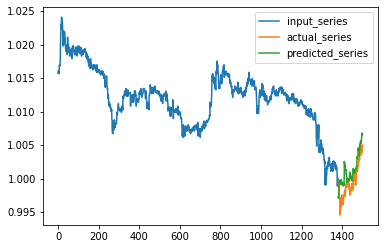

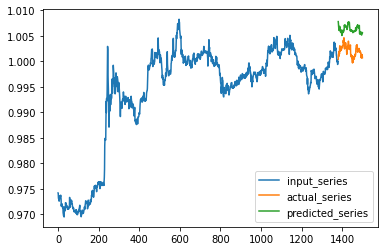

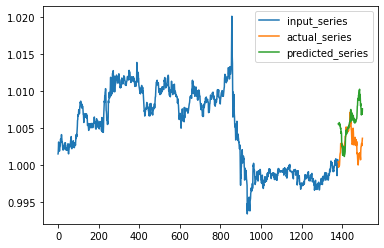

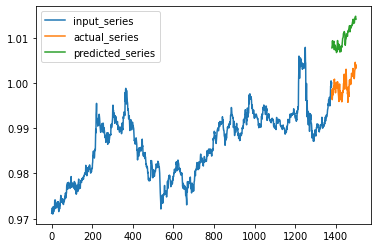

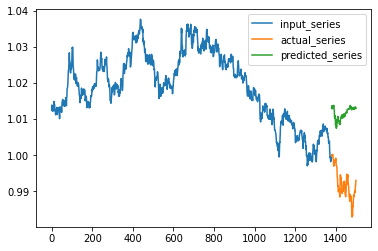

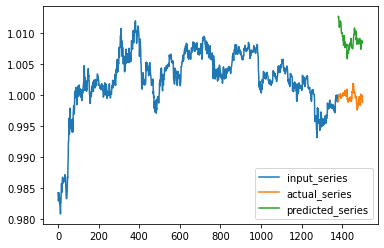

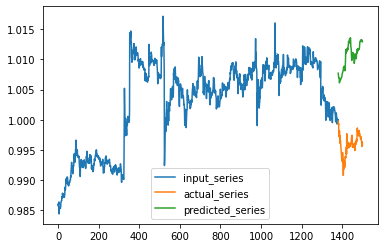

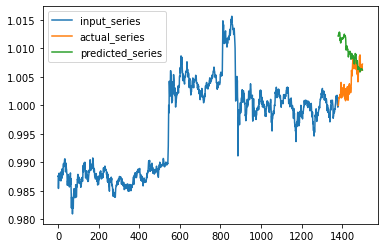

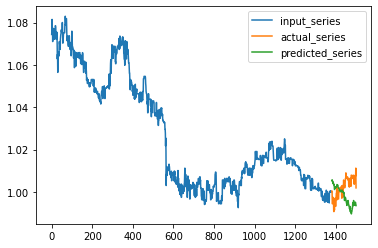

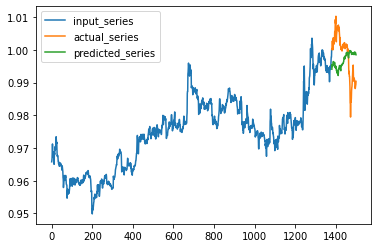

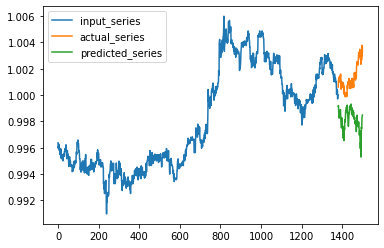

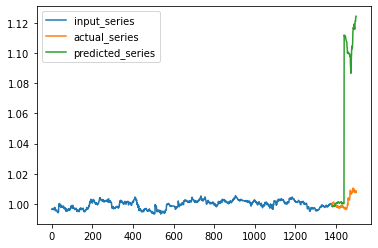

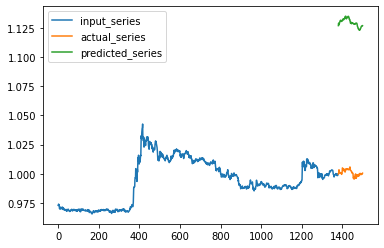

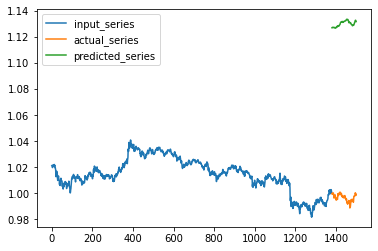

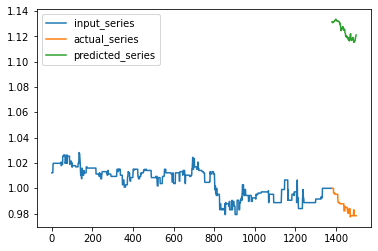

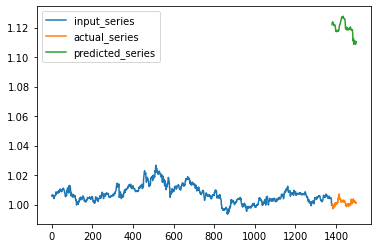

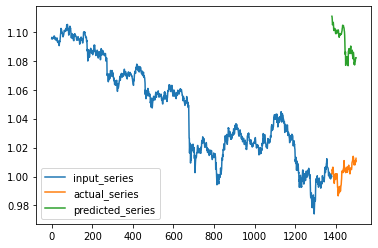

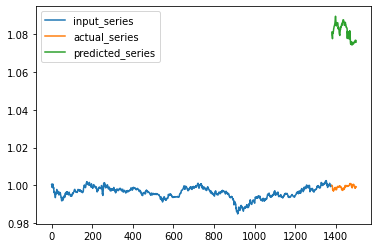

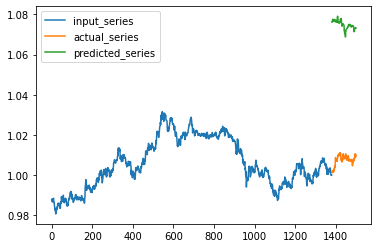

In [42]:
y_train_open = y_train[:,:,1]

for i in range(30): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()


In [39]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 30/30 [00:00<00:00, 49383.49it/s]


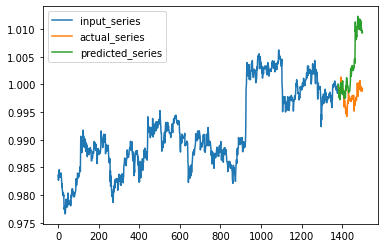

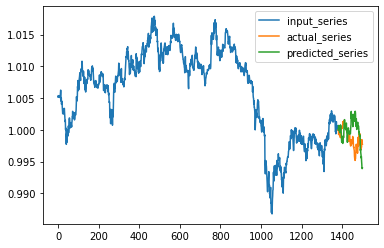

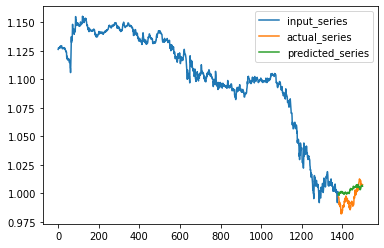

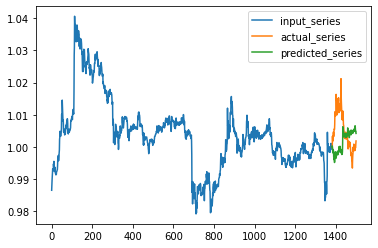

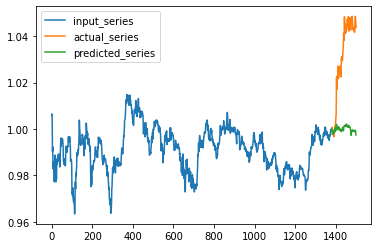

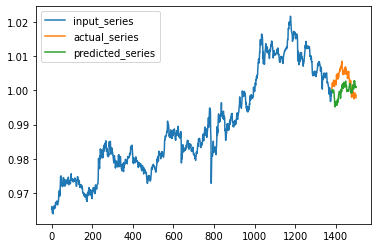

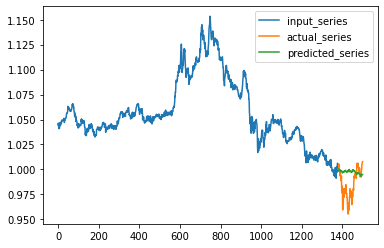

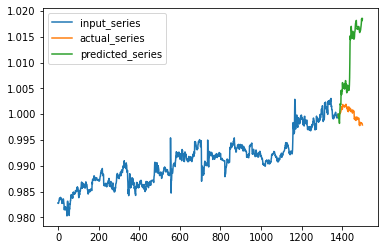

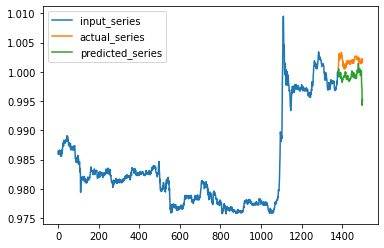

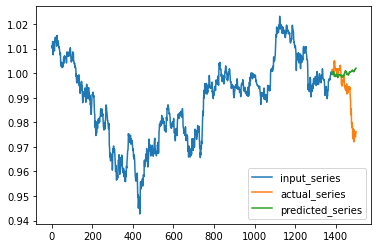

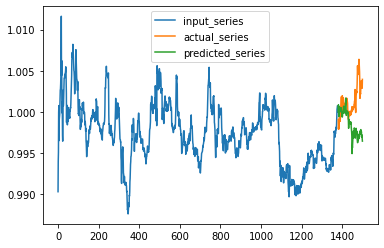

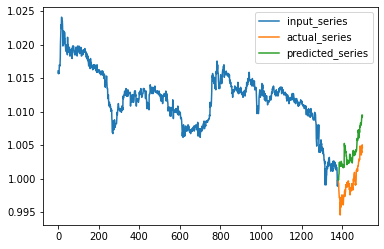

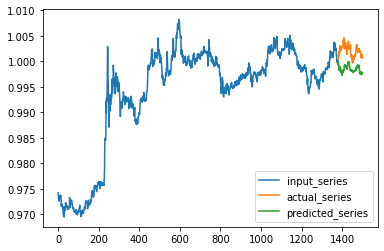

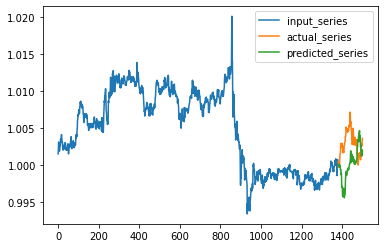

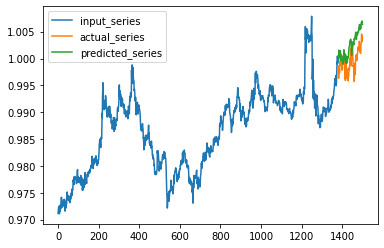

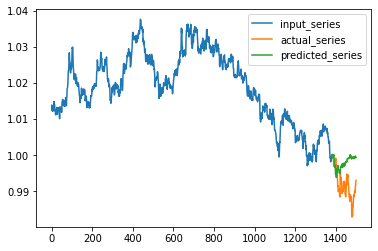

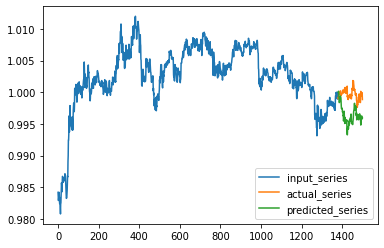

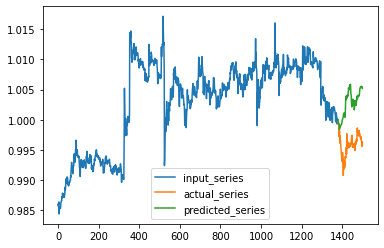

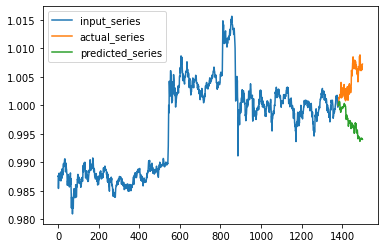

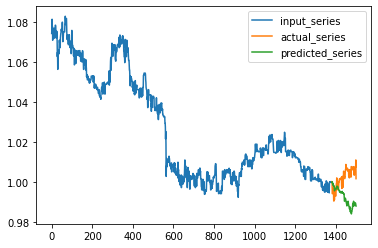

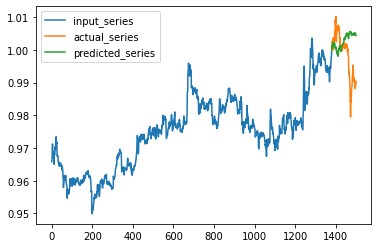

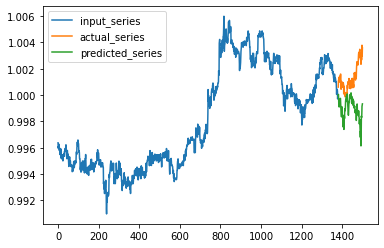

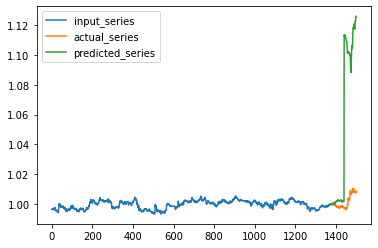

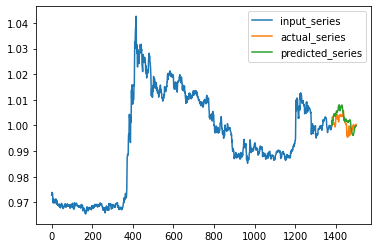

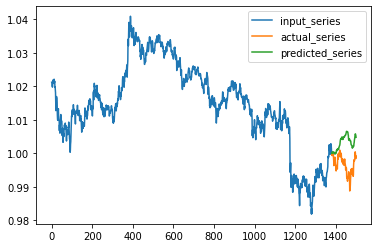

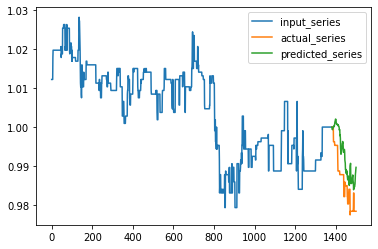

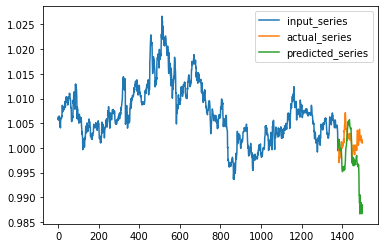

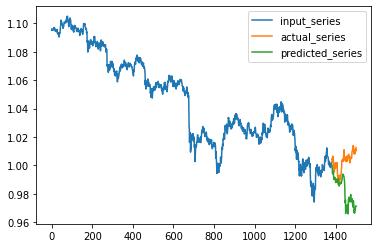

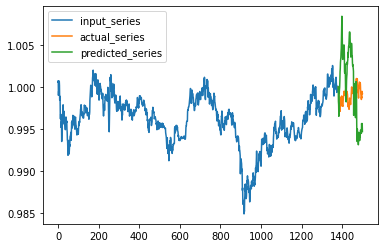

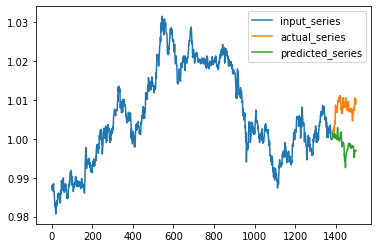

In [40]:
y_train_open = y_train[:,:,1]

for i in range(30): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()
